In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys

import cPickle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error
from lstm import x_sin, sin_cos, generate_data, lstm_model
import os
from tqdm import tqdm
import seaborn as sns
sys.path.append("/Users/danshiebler/Documents/music_rnn")
import pygame
from matplotlib import pyplot as plt
import midi_util
import feature_encoder
import music_lstm
import time
#RATHER THAN USE A HUGE DIRECT INTEGER ENCODING - TRY A DICTIONARY MAPPING

def dump_midi(midi_vec, filename, time_step=32, resolution=480, n=128):
    M  = midi_util.MidiWriter()
    M.dump_sequence_to_midi(midi_vec, filename, time_step, resolution)

def plot_midi(midi_vec, n=128):
    plt.imshow(midi_vec, extent=[0, 1, 0, 1])

train_files = !ls music_all/train
test_files = !ls music_all/test
cv_files = !ls music_all/valid

resolution = 480
time_step = 120
train_examples = [midi_util.parse_midi_to_sequence("music_all/train/{}".format(f), time_step=time_step) for f in train_files]
test_examples = [midi_util.parse_midi_to_sequence("music_all/test/{}".format(f), time_step=time_step) for f in test_files[:5]]
# cv_examples = [midi_util.parse_midi_to_sequence("music_all/valid/{}".format(f), time_step=time_step) for f in cv_files]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#run once
timestep = 200
learning_rate = 0.001
n_steps = timestep
n_classes = train_examples[0].shape[1]
n_hidden = 128 # hidden layer num of features

        
        
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_classes])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = music_lstm.RNN(x, weights, biases, n_classes, timestep, n_hidden)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()
print "complete"

complete


In [88]:
# Launch the graph
# sess.close()

display_step = 10
NUM_THREADS  = 4
start = time.time()
sess =  tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=NUM_THREADS))
sess.run(init)

# Keep training until reach max iterations
for step, ex in enumerate(train_examples):
    batch_x, batch_y = music_lstm.get_forecast_Xy(ex, timestep)
    if not len(batch_x):
        continue
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    if step % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
        # Calculate batch loss
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        print "Iter " + str(step) + ", Minibatch Loss= " + \
              "{:.6f}".format(loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc) + ", Time Elapsed: {}".format(time.time() - start)
print "Optimization Finished! {} seconds elapsed".format(time.time() - start)




Iter 0, Minibatch Loss= 12.174850, Training Accuracy= 0.01630, Time Elapsed: 14.0099852085
Iter 10, Minibatch Loss= 15.178966, Training Accuracy= 0.00000, Time Elapsed: 93.3476750851
Iter 20, Minibatch Loss= 13.945848, Training Accuracy= 0.12917, Time Elapsed: 116.655647039
Iter 30, Minibatch Loss= 11.558883, Training Accuracy= 0.01285, Time Elapsed: 227.690146208
Iter 40, Minibatch Loss= 15.923075, Training Accuracy= 0.02869, Time Elapsed: 277.989197016
Optimization Finished! 282.743499041 seconds elapsed


100%|██████████| 1000/1000 [00:12<00:00, 77.83it/s]


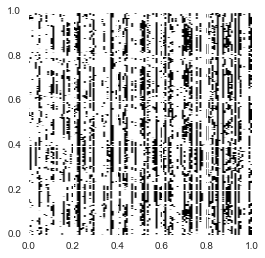

In [84]:
primer = music_lstm.get_forecast_Xy(test_examples[0], timestep)[0][0]
predictions = music_lstm.compose(x, sess, pred, primer, steps=1000)
plot_midi(predictions)

In [85]:
dump_midi(predictions, "music_outputs/composition.midi")

In [87]:

dump_midi(train_examples[0], "music_outputs/sample.midi")
